## EDA набора данных Russian traffic sign images dataset (RTSD)

In [1]:
# установка библиотек
! pip install numpy pandas matplotlib seaborn plotly

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import os
import json
from ast import literal_eval

import numpy as np 
import pandas as pd 
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Предисловие

<p style='font-size: 12pt'> 
    Распознавание знаков на изображении остаётся сложной
задачей по нескольким причинам:
    <ol style='font-size: 12pt'>
        <li>Классов дорожных знаков много (156 в базе, представленной в данной работе), они сильно отличаются формой и рисунком. Существующие системы помощи водителю находят ограниченный набор классов (ограничение скорости, стоп, уступи дорогу, пешеходный переход), что упрощает задачу.</li>
        <li>Для таких задач, как мониторинг дорог и построение карт, решение должно работать с полнотой,
    близкой к 100% и 1 ложным обнаружением на минуту видеопотока. Такое количество ложных обнаружений достигается при точности более 90%.</li>
        <li>Для задачи системы помощи водителю решение должно работать в реальном времени. Дорожные знаки на изображении могут быть  небольшого размера (от 16×16 пикселей), и для их выделения обычно строится многомасштабная пирамида изображения, в которой поиск производится окном с небольшим шагом (например, 4 пикселя). В результате получается порядка миллиона возможных положений окна в пирамиде, и для работы в реальном времени алгоритм выделения знаков должен быстро отбрасывать ложные обнаружения.</li>
        <li>Различные погодные условия (дождь, снег, яркое солнце) и перекрытия объектов из-за динамического окружения усложняют задачу</li>
    </ol>
</p>

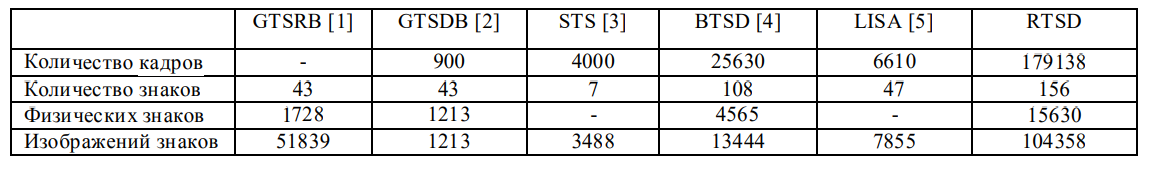

<p style='font-size: 12pt'> 
    <b> Синтетические данные:</b>
    В статье "Evaluation of Traffic Sign Recognition Methods Trained on Synthetically Generated Data" для обучения классификатора дорожных знаков используются синтетические изображения знаков. Свёрточная нейронная сеть, обученная на таких данных, показывает качество, сравнимое с нейронной сетью, обученной на реальных данных. Это позволяет решить проблему нерепрезентативных выборок и редко встречающихся классов знаков. 
</p>
<p style='font-size: 12pt'> 
    Однако эксперименты в статье "A system for large-scale automatic traffic sign recognition and mapping" показывают, что детектор дорожных знаков, обученный на синтетических данных, показывает неудовлетворительное качество.
</p>
<p style='font-size: 12pt'> 
    <b>Каскады нейронных сетей:</b>
    В статье "A convolutional neural network cascade for face detection" каскад из трёх нейронных сетей используется для быстрого и качественного выделения лиц на изображении. Этот метод является перспективным и для задачи выделения дорожных знаков на изображении.
</p>

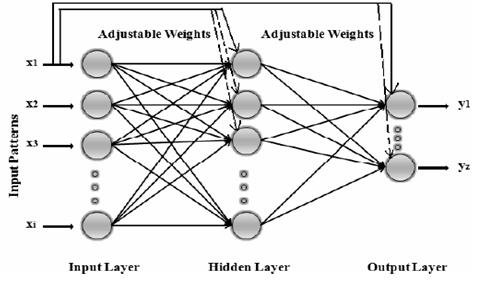
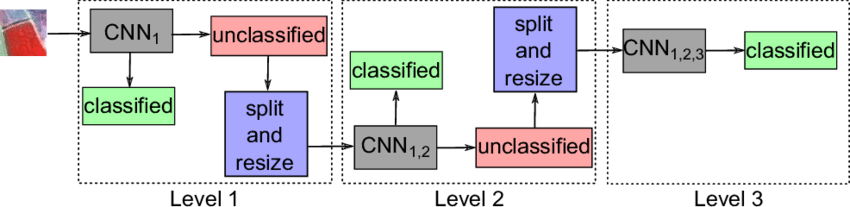

<p style='font-size: 12pt'>
    <b>Датасет:</b> При составлении датасета использовались кадры, предоставленные компанией Геоцентр-Консалтинг (http://geocenter-consulting.ru).
</p>
<p style='font-size: 12pt'>
    <ul style='font-size: 12pt'>
        <li>Разрешения кадров: 1280×720 до 1920×1080</li>
        <li>Кадры сняты в различные времена года (весна, осень, зима), времена суток (утро,
    день, вечер) и при различных погодных условиях (дождь, снег, яркое солнце)</li>
    </ul>
</p>

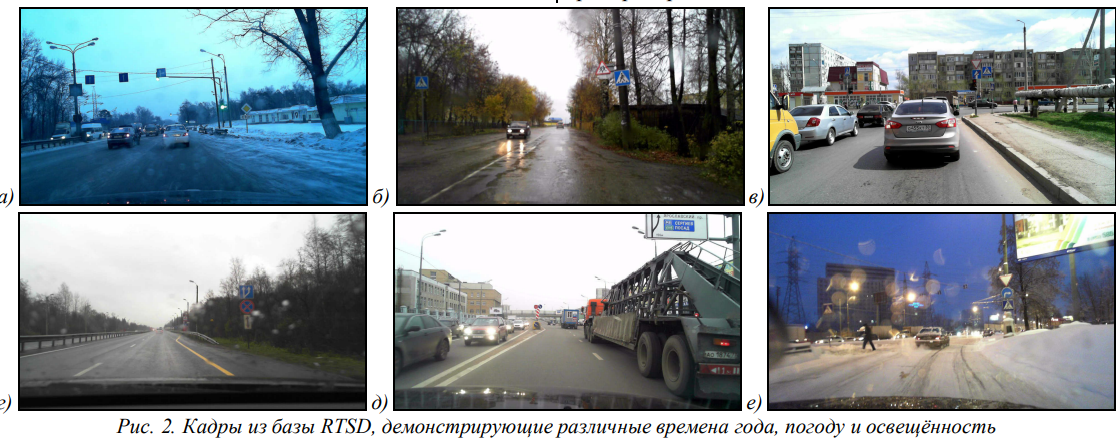

<p style='font-size: 12pt'>
    <b>Раметка:</b> Исходные коды программ для  разметки треков объектов и классов дорожных знаков распространяются вместе с базой RTSD. 
</p> 

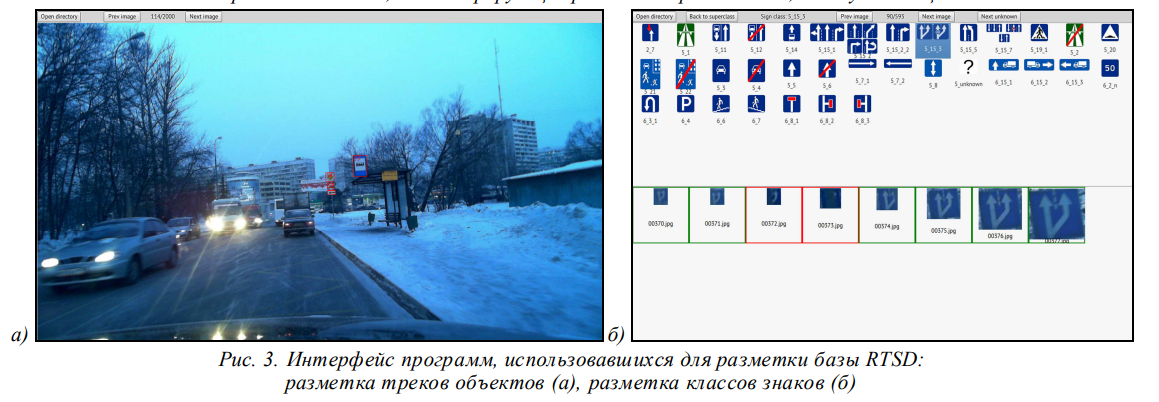

In [4]:
df = pd.read_csv('../data/dataset_signs.csv')
df.shape

(104358, 8)

<p style='font-size: 12pt'>
В датасете 104 358 строк, обещающих, что на данном изображении найден дорожный знак. \
Снимков, полученных в результате веб-скрейпинга, составило 2 415 (по результатам 'data_extraction.ipynb'). Количество найденных на них дорожных знаков может быть меньше, может быть больше.
</p>
<p style='font-size: 12pt'>
Таким образом, грубое приближение об общем объеме датасета 104 358 + 2 415 = 106 773 обнаружений дорожных знаков. В дальнейшем после разметки сырых данных это число будет уточнено и скорректировано.
</p>
<p style='font-size: 12pt'>
Далее проведем разведочный анализ размеченной части датасета.
</p>

## Разведочный анализ

<p style='font-size: 12pt'>
    Описание полей датасета
    <ul  style='font-size: 12pt'>
        <li>width - ширина изображения</li>
        <li>height - высота изображения</li>
        <li>file_name - имя изображения в файловой системе</li>
        <li>image_id - уникальный идентификатор изображения</li>
        <li>category_id - уникальный идентификатор дорожного знака</li>
        <li>category_name - идентификатор дорожного знака согласно ПДД</li>
        <li>bbox - начальный угол (x, y) высота (h), ширина(w) рамки дорожного знака</li>
        <li>area - регион/местность</li>
        <li>iscrowd - </li>
    </ul>        
</p>

In [5]:
df.head()

width  height                                    file_name  image_id  \
0   1280     720  rtsd-frames/autosave01_02_2012_09_13_33.jpg         0   
1   1280     720  rtsd-frames/autosave01_02_2012_09_13_34.jpg         1   
2   1280     720  rtsd-frames/autosave01_02_2012_09_13_35.jpg         2   
3   1280     720  rtsd-frames/autosave01_02_2012_09_13_36.jpg         3   
4   1280     720  rtsd-frames/autosave01_02_2012_09_13_37.jpg         4   

   category_id  area                bbox category_name  
0            1   324  [649, 376, 18, 18]           2_1  
1            1   420  [671, 356, 20, 21]           2_1  
2            1   702  [711, 332, 27, 26]           2_1  
3            1  1332  [764, 290, 37, 36]           2_1  
4            1  3192  [876, 200, 56, 57]           2_1

##### Размер датасета:

In [6]:
df.shape

(104358, 8)

##### Типы данных:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104358 entries, 0 to 104357
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   width          104358 non-null  int64 
 1   height         104358 non-null  int64 
 2   file_name      104358 non-null  object
 3   image_id       104358 non-null  int64 
 4   category_id    104358 non-null  int64 
 5   area           104358 non-null  int64 
 6   bbox           104358 non-null  object
 7   category_name  104358 non-null  object
dtypes: int64(5), object(3)
memory usage: 6.4+ MB


Преобразуем поле 'bbox' к удобному формату для дальнейшей работы

In [8]:
for index, row in df.iterrows():
    df['bbox'][index] = literal_eval(row['bbox'])

##### Пропуски в данных:

In [9]:
df.isna().sum()

width            0
height           0
file_name        0
image_id         0
category_id      0
area             0
bbox             0
category_name    0
dtype: int64

##### Уникальных снимков:

In [10]:
df['file_name'].describe()

count                                            104358
unique                                            59188
top       rtsd-frames/autosave13_04_2013_09_58_31_0.jpg
freq                                                 11
Name: file_name, dtype: object

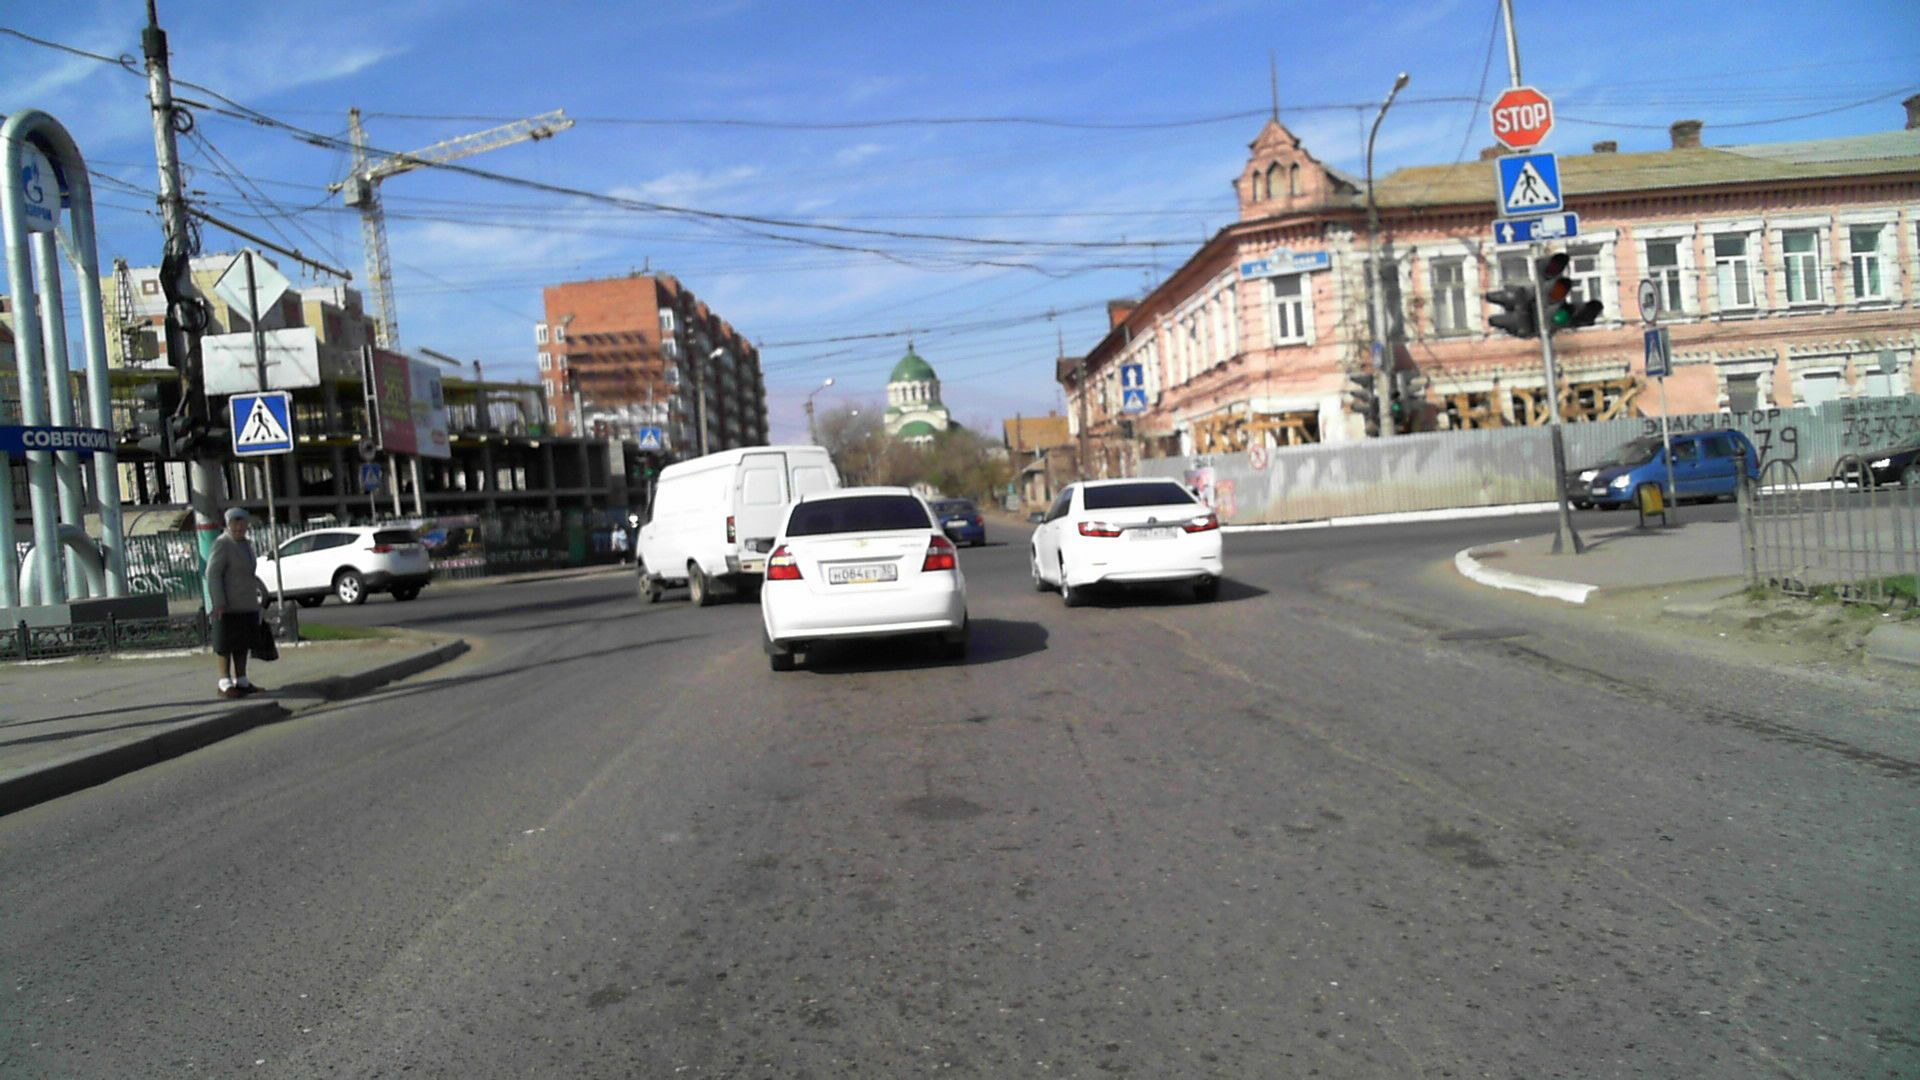

В датасете сделан акцент на довольно мелкие изображения знаков и с большим углом поворота.

##### Категорий знаков:

In [11]:
df['category_name'].describe()

count     104358
unique       155
top       5_19_1
freq       24264
Name: category_name, dtype: object

In [12]:
df['category_name'].value_counts()

category_name
5_19_1    24264
2_1       10961
5_16       5172
5_15_2     4944
3_24       4104
          ...  
8_23          3
8_3_3         2
4_5           2
3_33          1
2_3_5         1
Name: count, Length: 155, dtype: int64

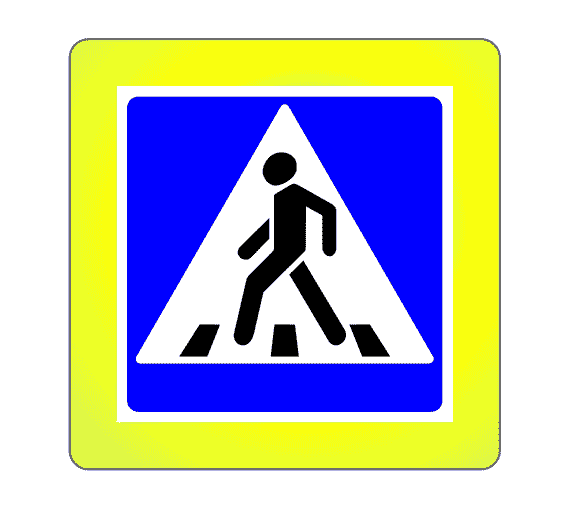
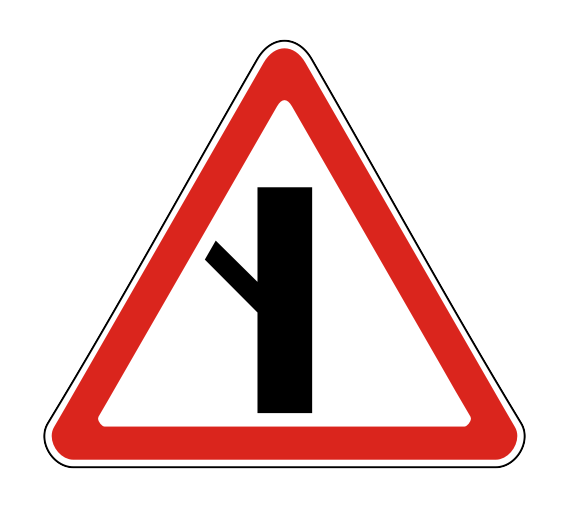

In [13]:
grouped_data = df.groupby('category_name').size().reset_index(name='count')
grouped_data = grouped_data.sort_values(by='count', ascending=False)
fig = px.bar(grouped_data, x='category_name' ,y ='count', 
             labels={'category_name': 'category_name'}, color_discrete_sequence=['blue'], 
             title=f'Distribution of sign_class')
fig.show()

В датасете представлено 155 уникальных дорожных знака. В интернете данные о точном количестве знаков разнятся, но усредненное значение равно +-300 знаков.

Наиболее часто встречаемый (24264 раз) - знак пешеходного перехода. Количество самого популярного класса в 2 с лишним раза больше, чем второго по популярности. Также присутствуют знаки с частотой 1 - 3 раза.

##### Размеры изображений:

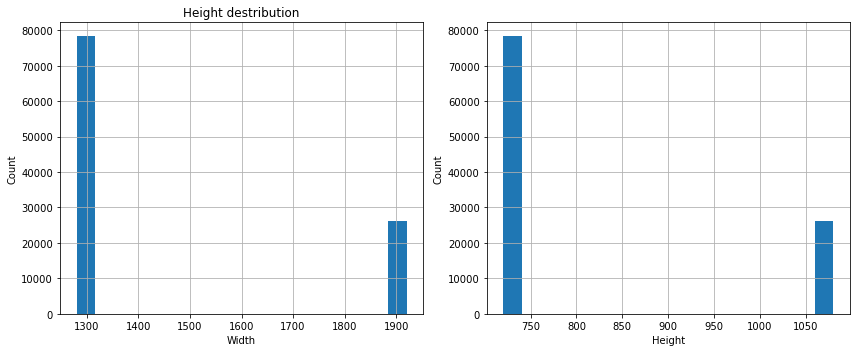

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Для выбора числа бинов используем формулу Стерджеса
axs[0].hist(df['width'], bins=round(1 + np.log2(df.shape[0])))
axs[1].hist(df['height'], bins=round(1 + np.log2(df.shape[0])))

axs[0].set_xlabel('Width')
axs[0].set_ylabel('Count')
axs[0].grid()
axs[0].set_title('Width destribution')

axs[1].set_xlabel('Height')
axs[1].set_ylabel('Count')
axs[1].grid()
axs[0].set_title('Height destribution')

fig.tight_layout()
plt.show()

<AxesSubplot:>

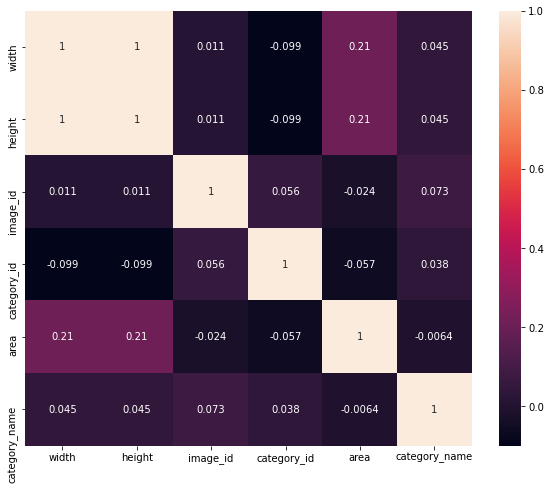

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.drop(['file_name', 'bbox'], axis=1).corr(), annot=True)

Есть корреляция ширины и высоты изображения, что очевидно, тк это размеры изображения с определенным соотношеним сторон.

##### Регион/местность:

In [16]:
df['area'].value_counts()

area
420      1335
462      1319
506      1280
552      1246
380      1239
         ... 
10492       1
10836       1
16445       1
8720        1
2201        1
Name: count, Length: 4239, dtype: int64

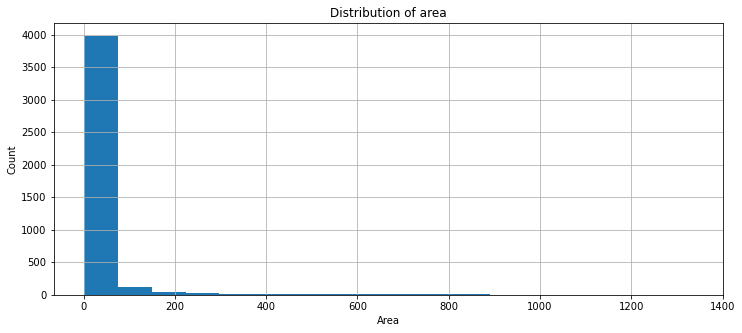

In [17]:
# Для выбора числа бинов используем формулу Стерджеса
fig = plt.figure(figsize=(12, 5))

plt.hist(df['area'].value_counts(), bins=round(1 + np.log2(df.shape[0])));

plt.xlabel('Area')
plt.ylabel('Count')
plt.title('Distribution of area')
plt.grid()

plt.show()

In [ ]:
df.to_csv('../data/dataset_signs.csv', index=False)

### Область применения датасета

<p style='font-size: 12pt'>
Полученные данные могут быть использованы при обучении моделей МО, решающих задачу детекции в видеопотоке знаков дорожного движения. 
</p>
<p style='font-size: 12pt'>
Разработанный клиент может быть использован следующих случаях:
    <ol style='font-size: 12pt'>
    <li>водителями для дополнительного оповещения (в случае движения в крупном мегаполисе) или рекомендаций по принятию решений (ADAS, Advanced Driver Assistance Systems);</li>
    <li>инструкторами по вождению на своих занятиях для развития навыка студента смотреть на дорожные знаки во время движения;</li>
    <li>при автоматическом составлении и пополнении навигационных карт;</li>
    <li> в системах мониторинга знаков на дорогах для служб дорожного хозяйства;</li>
    <li> в совокопнуости со множеством других технологий (датчики, сенсоры и тп) обученная модель может быть использована в беспилотных автомобилях или автомобилях с режимом автопилот.
    </ol>
</p>